# Import Libraries, Load Data

### Imports

In [5]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

### Setting up Data

In [6]:
# Paths:
#price_path = "/Users/amilamuthunayake/Documents/Trading_Research/correlation_matrix_spectral_clustering/get_shardar_all_equity_based_on_cap/price_data_from_shardar.csv"
#cap_path = "/Users/amilamuthunayake/Documents/Trading_Research/correlation_matrix_spectral_clustering/get_shardar_all_equity_based_on_cap/cap_data_from_shardar.csv"
price_path = '/Users/tuckeringlefield/Desktop/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/DNR_Data/FinanceData/cap_data_from_shardar.csv'
#price_path = "C:/Users/Owner/school/math4920/price_data_from_shardar.csv"
#cap_path = "C:/Users/Owner/school/math4920/cap_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [7]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
# df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


# Functions

## Helper Functions

In [8]:
# Function to find the top ten largest market cap stocks
def find_top_liquid_stocks(date_end, num_stocks):
    global caps_df
    selected_row = caps_df.iloc[date_end]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(num_stocks).index.tolist()
    return stocks_list

In [9]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    filtered_df = filtered_df.dropna()
    return filtered_df

In [10]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [11]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    #res_df = pd.DataFrame()
    res_df = {}
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    res_df = pd.DataFrame(res_df)
    return res_df

In [12]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict

In [13]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          if pvalue1 < sig_level:
            pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
            if pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [14]:
# Function to find the cointegrated pairs
from statsmodels.tsa.stattools import adfuller
def find_cointegrated_pairs_manual(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          reg_coe = np.cov(dataframe[stock1], dataframe[stock2])[0, 1]/np.std(dataframe[stock2])
          res = dataframe[stock1] - reg_coe*dataframe[stock2]
          pvalue1 = adfuller(res)[1]
          if pvalue1 < sig_level:
            reg_coe = np.cov(dataframe[stock2], dataframe[stock1])[0, 1]/np.std(dataframe[stock1])
            res = dataframe[stock2] - reg_coe*dataframe[stock1]
            pvalue2 = adfuller(res)[1]
            if pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [15]:
# Function to check on existing pairs
def is_still_cointegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [16]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return math.floor(beta*100)/100

In [17]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')
        
    # print(dataframe[stocks_list])

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [18]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, mean

## Main Functions

In [19]:
# Helper to calculate spread
def calculate_spread(window_stock_data, stock_pair, stock_data):
    stock1_last_price = window_stock_data[stock_pair[0]].dropna().iloc[-1]
    stock2_last_price = window_stock_data[stock_pair[1]].dropna().iloc[-1]
    return stock1_last_price - float(stock_data["current_hedge_ratio"]) * stock2_last_price

# Helper to open a trade if conditions are met
def open_trade_if_needed(spread, stock_pair, stock_data, spread_return_percentages, trade_close_dates, current_day, currently_trading_stocks):
    # Logic to check conditions and open trade
    if abs(spread - stock_data["current_spread_mean"]) > stock_data["spread_upper_limit"]:
        stock_data["currently_trading"] = True
        stock_data['trade_info']["open_trade_dates"].append((current_day, spread))
        print(f"Opening trade for {stock_pair} on {current_day}, spread: {spread}")
        currently_trading_stocks.extend(stock_pair)
    return spread_return_percentages, trade_close_dates

# Helper to close a trade if conditions are met
def close_trade_if_needed(spread, stock_pair, stock_data, spread_return_percentages, trade_close_dates, current_day, currently_trading_stocks):
    # Logic to check conditions and close trade
    if abs(spread - stock_data["current_spread_mean"]) < stock_data["spread_lower_limit"]:
        stock_data["currently_trading"] = False
        stock_data['trade_info']["close_trade_dates"].append((current_day, spread))
        print(f"Closing trade for {stock_pair} on {current_day}, spread: {spread}")
        # Calculate percentage return (example logic)
        open_spread = stock_data['trade_info']['open_trade_dates'][-1][1]
        percent_return = (open_spread - spread) / open_spread * 100
        spread_return_percentages.append(percent_return)
        trade_close_dates.append(current_day)
        currently_trading_stocks.remove(stock_pair[0])
        currently_trading_stocks.remove(stock_pair[1])
    return spread_return_percentages, trade_close_dates

def reset_hedge_and_spread_if_needed(currently_monitoring_pairs, existing_stocks):
    # Iterate through a copy of currently monitoring pairs to avoid modifying the list during iteration
    for stock_pair in currently_monitoring_pairs.copy():
        # Check if the stock pair is no longer currently trading
        if existing_stocks[stock_pair]["currently_trading"] == False:
            # Reset current spread mean and hedge ratio to None
            existing_stocks[stock_pair]["current_spread_mean"] = None
            existing_stocks[stock_pair]["current_hedge_ratio"] = None

def cluster_and_monitor_new_pairs(liquid_stocks_not_null, window_start_index, window_end_index, currently_monitoring_pairs, existing_stocks):
    global prices_with_market, num_clusters  # Access the global variable

    # Create a DataFrame of differences for the specified window of stock data
    diff_df = filter_diff_df(prices_with_market, window_start_index, window_end_index, liquid_stocks_not_null)
    # Filter the price DataFrame to get only highly liquid stocks for the specified dates
    window_highly_liquid_stocks_price_df = filter_df_by_dates(prices_with_market, window_start_index, window_end_index, liquid_stocks_not_null)
    # Calculate betas for the stocks in the specified window
    beta_df = calculate_betas(diff_df, window_start_index, window_end_index, liquid_stocks_not_null)

    # Merge difference DataFrame with beta DataFrame for further analysis
    merged_df = diff_df.merge(beta_df, how='cross')
    # Calculate residuals for the merged DataFrame
    res_df = calculate_residuals(merged_df, liquid_stocks_not_null)
    # Cluster the residuals to find cointegrated stock pairs
    cluster_dict = cluster_the_matrix(res_df, num_clusters)
    # Find cointegrated pairs from the clustered stocks
    clustered_stock_pairs = find_cointegrated_pairs(window_highly_liquid_stocks_price_df, cluster_dict, 0.05)

    # Iterate over each clustered stock pair
    for stock_pair in clustered_stock_pairs:
        # Destructure to check if the pair already exists in existing_stocks
        stock1, stock2 = stock_pair
        # If the stock pair is not already being monitored
        if (stock1, stock2) not in existing_stocks and (stock2, stock1) not in existing_stocks:
            # Start monitoring this new pair
            existing_stocks[stock_pair] = {
                "is_cointegrated": True,
                "should_monitor": True,
                "trade_status_message": "Looking for trading days",
                "monitoring_start_dates": [prices_with_market.iloc[window_end_index].name.strftime('%Y-%m-%d')],
                "monitoring_end_dates": [],
                "trade_info": {
                    "open_trade_dates": [],
                    "close_trade_dates": [],
                },
                "trade_day_spread_position": "unknown",
                "current_hedge_ratio": None,
                "current_spread_mean": None,
                "spread_upper_limit": None,
                "spread_lower_limit": None,
                "currently_trading": False
            }
            # Add the stock pair to the list of currently monitoring pairs
            currently_monitoring_pairs.append(stock_pair)
        else:
            # If it is already in existing_stocks, determine the correct stock pair order
            if (stock1, stock2) in existing_stocks:
                stock_pair = (stock1, stock2)
            else:
                stock_pair = (stock2, stock1)
            # Check if the stock pair was being monitored last week
            if existing_stocks[stock_pair]["should_monitor"]:
                continue  # If yes, skip to the next pair
            else:
                # Stock pair was not being monitored last week; start monitoring it now
                existing_stocks[stock_pair]["monitoring_start_dates"].append(prices_with_market.index[window_end_index].strftime('%Y-%m-%d'))
                existing_stocks[stock_pair]["should_monitor"] = True
                existing_stocks[stock_pair]["trade_status_message"] = "Looking for trading days"
                existing_stocks[stock_pair]["is_cointegrated"] = True
                currently_monitoring_pairs.append(stock_pair)  # Add to currently monitoring pairs

def manage_daily_spreads(window_size, currently_monitoring_pairs, window_end_index, existing_stocks, currently_trading_stocks, spread_return_percentages, number_trades_allowed, trade_close_dates):
    global prices_with_market  # Access the global variable

    # Initialize a counter for currently opened trades
    current_trade_count = sum(existing_stocks[stock_pair]["currently_trading"] for stock_pair in currently_monitoring_pairs)

    # Iterate over currently monitoring stock pairs
    for stock_pair in currently_monitoring_pairs:
        # Check if either stock's price is null
        if ((pd.isna(prices_with_market[stock_pair[0]].iloc[window_end_index])) or (pd.isna(prices_with_market[stock_pair[1]].iloc[window_end_index]))):
            # Check if there is an open trade for this pair
            if (len(existing_stocks[stock_pair]['trade_info']['open_trade_dates']) > len(existing_stocks[stock_pair]['trade_info']['close_trade_dates'])):
                # Close trade due to liquidity issue
                current_day_string = prices_with_market.iloc[window_end_index].name.strftime('%Y-%m-%d')
                prev_day_spread = prices_with_market[stock_pair[0]].iloc[window_end_index - 1] - float(existing_stocks[stock_pair]["current_hedge_ratio"]) * prices_with_market[stock_pair[1]].iloc[window_end_index - 1]
                existing_stocks[stock_pair]["currently_trading"] = False
                # Record close trade information
                existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'Null values', prev_day_spread))
                # Calculate spread difference percentage
                open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                    percent_return = ((open - prev_day_spread) / total_investment) * 100   
                else:
                    percent_return = ((prev_day_spread - open) / total_investment) * 100
                # Format the percentage and log it
                percent_formatted = math.floor(percent_return * 100) / 100
                print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                spread_return_percentages.append(percent_formatted)
                # Remove stocks from currently trading list
                currently_trading_stocks.remove(stock_pair[0])
                currently_trading_stocks.remove(stock_pair[1])

            # Close out the monitoring period for this stock pair
            existing_stocks[stock_pair]["should_monitor"] = False
            existing_stocks[stock_pair]["current_spread_mean"] = None
            existing_stocks[stock_pair]["current_hedge_ratio"] = None
            existing_stocks[stock_pair]["is_cointegrated"] = None
            existing_stocks[stock_pair]["trade_status_message"] = 'Null values'
            existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
            existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
            currently_monitoring_pairs.remove(stock_pair)  # Remove from monitoring pairs

        # If still trading or not in currently trading stocks
        if existing_stocks[stock_pair]["currently_trading"] or (stock_pair[0] not in currently_trading_stocks and stock_pair[1] not in currently_trading_stocks):
            # Call monitor_pair_for_day to assess daily spreads
            existing_stocks[stock_pair], spread_return_percentages = monitor_pair_for_day(window_size, stock_pair, existing_stocks[stock_pair], window_end_index, currently_trading_stocks, spread_return_percentages, trade_close_dates, number_trades_allowed)
 
            # If we need to open a trade and we have not exceeded the limit
            if not existing_stocks[stock_pair]["currently_trading"] and current_trade_count < number_trades_allowed:
                spread = calculate_spread(prices_with_market, stock_pair, existing_stocks[stock_pair])
                spread_return_percentages, trade_close_dates = open_trade_if_needed(spread, stock_pair, existing_stocks[stock_pair], spread_return_percentages, trade_close_dates, prices_with_market.iloc[window_end_index].name, currently_trading_stocks)
                
                # Increment the count of open trades after successfully opening one
                current_trade_count += 1  

            # Handle closing trades logic here
            spread_return_percentages, trade_close_dates = close_trade_if_needed(spread, stock_pair, existing_stocks[stock_pair], spread_return_percentages, trade_close_dates, prices_with_market.iloc[window_end_index].name, currently_trading_stocks)

    return existing_stocks, spread_return_percentages, trade_close_dates


In [20]:
def monitor_pair_for_day(window_size, stock_pair, stock_data, window_end_index, currently_trading_stocks, spread_return_percentages, trade_close_dates, number_trades_allowed):
    global prices_with_market

    # Debugging
    print(f"prices_with_market shape: {prices_with_market.shape}")
    print(f"window_end_index: {window_end_index}, window_size: {window_size}")

    window_stock_data = prices_with_market[window_end_index - window_size:window_end_index + 1]
    current_day = window_stock_data.index[-1].strftime('%Y-%m-%d')
    
    # Calculate the spread
    spread = calculate_spread(window_stock_data, stock_pair, stock_data)

    # Check if pair is already trading
    if stock_data["currently_trading"]:
        # Close trade logic if spread conditions are met
        spread_return_percentages, trade_close_dates = close_trade_if_needed(
            spread, stock_pair, stock_data, spread_return_percentages, 
            trade_close_dates, current_day, currently_trading_stocks
        )
    else:
        # Open trade logic if necessary, and trade limit is not exceeded
        if len(stock_data["trade_info"]["open_trade_dates"]) < number_trades_allowed:
            spread_return_percentages, trade_close_dates = open_trade_if_needed(
                spread, stock_pair, stock_data, spread_return_percentages, 
                trade_close_dates, current_day, currently_trading_stocks
            )

    return stock_data, spread_return_percentages, trade_close_dates

In [21]:
def monitor_pairs(window_size, stock_group_size, stop_after_days, number_trades_allowed):
    global prices_with_market, num_clusters
    currently_trading_stocks = []
    existing_stocks = {}
    currently_monitoring_pairs = []
    spread_return_percentages = []
    trade_close_dates = []

    for day in range(stop_after_days):
        window_start_index = day
        window_end_index = day + window_size
        window_stock_data = prices_with_market[window_start_index: window_end_index + 1]

        dtype_day = window_stock_data.index[-1]
        current_day_string = dtype_day.strftime('%Y-%m-%d')

        if day % 7 == 0:
            print(f'----------- Weeks Running: {day // 7} --------------------')

            # Find new pairs
            top_liquid_stocks = find_top_liquid_stocks(window_end_index, stock_group_size)
            liquid_stocks_not_null = [
                stock for stock in top_liquid_stocks 
                if window_stock_data[stock].isnull().sum().item() == 0
            ]

            # Check if existing_stocks is empty (i.e., we haven't found any pairs yet)
            if existing_stocks:
                # Check for cointegration and reset parameters if necessary
                reset_hedge_and_spread_if_needed(
                    window_stock_data, currently_monitoring_pairs
                )

            # Clustering and identifying new stock pairs
            cluster_and_monitor_new_pairs(
                liquid_stocks_not_null, window_start_index, 
                window_end_index, currently_monitoring_pairs, existing_stocks
            )

        # Daily process to check spreads and manage trades
        manage_daily_spreads(
            window_size, currently_monitoring_pairs,
            window_end_index, existing_stocks, 
            currently_trading_stocks, spread_return_percentages,
            number_trades_allowed, trade_close_dates
        )

    return existing_stocks, spread_return_percentages, trade_close_dates

In [22]:
#if __name__ == '__main__':
    #import cProfile
    #cProfile.run('monitor_pairs(500, 30, 1000, 10)')

# Running Code

In [23]:
# Run Main code
import pprint as pprint

trade_open_dates = []
open_num_trades = []

num_days_to_run = 5000
window_size_in_days = 500
num_liquid_stocks_to_consider = 200
number_trades_allowed = 100
num_clusters = 12
results, spread_percentages, trade_close_dates = monitor_pairs(window_size_in_days, num_liquid_stocks_to_consider, num_days_to_run, number_trades_allowed)
pprint.pprint(results)
print(spread_percentages)

----------- Weeks Running: 0 --------------------
prices_with_market shape: (5787, 10807)
window_end_index: 500, window_size: 500


TypeError: float() argument must be a string or a real number, not 'NoneType'

In [ ]:
print(f'Mean: {np.mean(spread_percentages)}')
print(f'Sum: {np.sum(spread_percentages)}')

Mean: 0.18812054852769214
Sum: 3539.2999999999997


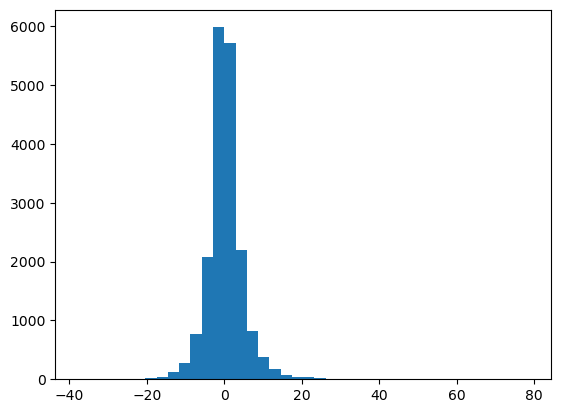

In [ ]:
plt.hist(spread_percentages, bins=40)
plt.show()

In [ ]:
pd.Series(open_num_trades).value_counts().sort_index(ascending=False)

77.0    1
76.0    1
75.0    1
74.0    1
73.0    1
       ..
4.0     1
3.0     1
2.0     1
1.0     1
0.0     1
Length: 78, dtype: int64

In [ ]:
pd.Series(spread_percentages).describe()

count    18814.000000
mean         0.188121
std          4.763699
min        -37.850000
25%         -2.000000
50%          0.010000
75%          2.230000
max         78.590000
dtype: float64

In [ ]:
spy_per_rates = (prices_with_market[window_size_in_days:window_size_in_days+num_days_to_run]['SPY'].pct_change()*100).cumsum().dropna()
spy_per_rates = spy_per_rates.to_frame()
spy_per_rates

,SPY
date,
2002-01-03,1.133876
2002-01-04,1.801487
2002-01-07,1.095825
2002-01-08,0.864635
2002-01-09,0.049304
...,...
2021-11-03,214.137757
2021-11-04,214.609009
2021-11-05,214.955987


In [ ]:
number_trades_allowed = 100
trade_returns = pd.DataFrame({'Date':trade_close_dates, 'Return': spread_percentages})
trade_returns['Return'] = trade_returns['Return']/number_trades_allowed

# Calculate the number of trades per Date
trade_counts = trade_returns.groupby('Date').size().rename('Trade_Count')

return_df = trade_returns.groupby('Date').sum()
return_df = return_df.cumsum()

# Add the trade counts to return_df
return_df = return_df.merge(trade_counts, on='Date', how='left')

return_df

,Return,Trade_Count
Date,,
2002-01-11,-0.254,18
2002-01-23,4.796,19
2002-02-01,9.469,26
2002-02-07,11.621,1
2002-02-12,16.202,26
...,...,...
2021-10-28,354.327,34
2021-10-29,354.313,1
2021-11-04,355.488,1


In [ ]:
merged_df = return_df.combine_first(spy_per_rates)
filled_df = merged_df.ffill()
filled_df

,Return,SPY,Trade_Count
2002-01-03,NaN,1.133876,NaN
2002-01-04,NaN,1.801487,NaN
2002-01-07,NaN,1.095825,NaN
2002-01-08,NaN,0.864635,NaN
2002-01-09,NaN,0.049304,NaN
...,...,...,...
2021-11-03,354.313,214.137757,1.0
2021-11-04,355.488,214.609009,1.0
2021-11-05,356.050,214.955987,1.0
2021-11-08,353.930,215.041353,24.0


In [ ]:
merged_df.Return.isnull().sum()

3845

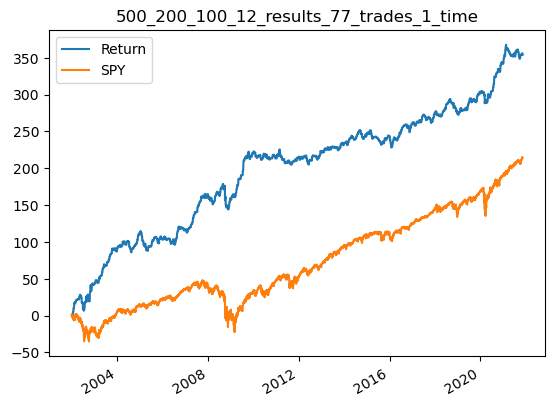

In [ ]:
filled_df[['Return', 'SPY']].plot()
plt.title('500_200_100_12_results_77_trades_1_time')
plt.show()

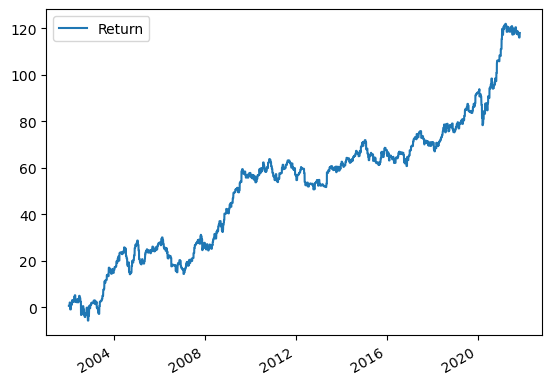

In [ ]:
filled_df[['Return']].plot()
plt.show()

In [ ]:
pd.DataFrame(results).to_csv('500_100_20_6_results_19_trades_508_times.csv')

In [ ]:
filled_df[['Return', 'SPY']].to_csv('500_100_20_6_cumsum.csv')

# Visualization

In [ ]:
def construct_periods(start_dates, end_dates):
    periods = []

    min_length = min(len(start_dates), len(end_dates))

    # Pair each start date with the corresponding end date
    for i in range(min_length):
        periods.append((start_dates[i], end_dates[i]))

    # Handle cases where the lists are of unequal length
    if len(start_dates) > len(end_dates):
        # If there are more start dates, pair the remaining ones with None (or a placeholder)
        for j in range(min_length, len(start_dates)):
            periods.append((start_dates[j], None))
    elif len(end_dates) > len(start_dates):
        # If there are more end dates, pair the remaining ones with the last start date
        for j in range(min_length, len(end_dates)):
            periods.append((start_dates[-1], end_dates[j]))

    return periods

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pprint

def print_overall_display(pairs_dictionary, days_ran):
    global prices_with_market

    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = pairs_dictionary

    num_pairs = len(filtered_data)
    num_needed_plots = 0
    if num_pairs % 20 != 0:
        num_needed_plots = num_pairs // 20 + 1
    else:
        num_needed_plots = num_pairs // 20

    # Sort the pairs into chunks for printing 
    indexing_var = 0
    keys = list(filtered_data.keys())
    plotting_dict = {}
    for plot in range(num_needed_plots):
        plotting_dict[f'Plot_{plot+1}'] = []
        for j in range(20):
            if indexing_var >= num_pairs:  # Fix for the off-by-one error
                break
            plotting_dict[f'Plot_{plot+1}'].append(keys[indexing_var])
            indexing_var += 1

    # Iterate over the plotting_dict to create plots
    for plot_name, pairs in plotting_dict.items():
        fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the size as needed
        print(f"Creating {plot_name} with pairs: {pairs}")

        # Get the data for the current set of pairs
        chunk_data = [(key, filtered_data[key]) for key in pairs if key in filtered_data]

        # Iterate over the chunk data to plot
        for idx, (key, value) in enumerate(chunk_data):
            label = f"{key[0]}-{key[1]}"

            # Extract monitoring periods
            periods_start = [str_to_date(date) for date in value['monitoring_start_dates']]
            periods_end = [str_to_date(date) for date in value['monitoring_end_dates']]
            periods = construct_periods(periods_start, periods_end)

            # Plot each period as a line
            for start, end in periods:
                if end is None:
                    # Move 'days_ran' rows forward from the start date to determine the end date
                    start_index = prices_with_market.index.get_loc(start.strftime('%Y-%m-%d'))
                    end_index = start_index + days_ran

                    # Ensure end_index does not exceed the length of the DataFrame
                    if end_index >= len(prices_with_market):
                        end_index = len(prices_with_market) - 1

                    end = prices_with_market.index[end_index]  # Get the string date at end_index
                else:
                    # Convert end to string format for consistency
                    end = end.strftime('%Y-%m-%d')

                ax.plot([start, end], [idx, idx], color='black')

            # Plot open trade dates as green dots
            open_trade_dates = [(str_to_date(date_info[0]), date_info[1], date_info[2], date_info[3], date_info[4]) 
                                for date_info in value['trade_info']['open_trade_dates']]

            if open_trade_dates:
                open_trade_dates_only = [date_info[0] for date_info in open_trade_dates]
                ax.plot(open_trade_dates_only, [idx] * len(open_trade_dates_only), 'o', color='green', label='Open Trade Dates' if idx == 0 else "")

            # Plot close trade dates as red dots
            close_trade_dates = [(str_to_date(date_info[0]), date_info[1], date_info[2]) 
                                 for date_info in value['trade_info']['close_trade_dates']]

            if close_trade_dates:
                close_trade_dates_only = [date_info[0] for date_info in close_trade_dates]
                ax.plot(close_trade_dates_only, [idx] * len(close_trade_dates_only), 'o', color='red', label='Close Trade Dates' if idx == 0 else "")

        # Formatting the plot
        y_labels = [f"{key[0]}-{key[1]}" for key, _ in chunk_data]
        if y_labels:
            ax.set_yticks(range(len(y_labels)))
            ax.set_yticklabels(y_labels, fontsize=10, horizontalalignment='right')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.title(f'Event Timelines for {plot_name}')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pprint import pprint

def print_trading_with_prices(dict, days_ran):
    global prices_with_market
    
    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = {
        key: value for key, value in dict.items()
        if (value.get('monitoring_start_dates') or value.get('monitoring_end_dates') or
            value.get('trade_info', {}).get('open_trade_dates') or value.get('trade_info', {}).get('close_trade_dates'))
    }
    
    for key in filtered_data:        
        # Safely access trade dates
        open_trade_dates = [item[0] for item in filtered_data[key].get('trade_info', {}).get('open_trade_dates', [])]
        close_trade_dates = [item[0] for item in filtered_data[key].get('trade_info', {}).get('close_trade_dates', [])]

        # Skip processing if there are no open trade dates
        if not open_trade_dates:
            continue  # Skip if there are no open trade dates

        # Determine the start date for plotting
        first_open_trade_date = str_to_date(open_trade_dates[0]) - timedelta(days=20)  # 20 days before

        # Determine the end date for plotting
        if close_trade_dates:
            last_close_trade_date = str_to_date(close_trade_dates[-1]) + timedelta(days=20)  # 20 days after
            try:
                plot_end_loc = prices_with_market.index.get_loc(last_close_trade_date)
            except KeyError:
                # Use the closest available date
                closest_date = prices_with_market.index[prices_with_market.index.get_indexer([last_close_trade_date], method='nearest')[0]]
                plot_end_loc = prices_with_market.index.get_loc(closest_date)
        else:
            # If no close trade dates, use days_ran parameter for the end of the plot
            last_open_trade_date = str_to_date(open_trade_dates[-1])
            try:
                plot_end_loc = prices_with_market.index.get_loc(last_open_trade_date) + days_ran
            except KeyError:
                # Use the closest available date
                closest_date = prices_with_market.index[prices_with_market.index.get_indexer([last_open_trade_date], method='nearest')[0]]
                plot_end_loc = prices_with_market.index.get_loc(closest_date) + days_ran

        # Ensure plot_end_loc does not exceed the length of the DataFrame
        if plot_end_loc >= len(prices_with_market):
            plot_end_loc = len(prices_with_market) - 1

        plot_end_date = prices_with_market.index[plot_end_loc]

        # Adjust plot_start_date to ensure it is within the DataFrame
        plot_start_date = max(prices_with_market.index[0], first_open_trade_date)

        # Plot the relevant prices
        try:
            prices_with_market[[key[0], key[1]]][plot_start_date:plot_end_date].plot()
            plt.title(f"{key}")

            # Prepare trade information for display
            trades_info = []
            num_trades = max(len(open_trade_dates), len(close_trade_dates))
            for i in range(num_trades):
                open_date = open_trade_dates[i]
                try:
                    close_date = close_trade_dates[i]
                    message = filtered_data[key]['trade_info']['close_trade_dates'][i][1]
                except IndexError:
                    close_date = ''
                    message = 'Stock in trade'
                string = f'({open_date}-{close_date}) : {message}'
                trades_info.append(string)    

            # Add vertical green lines for open_trade_dates
            for date in open_trade_dates:
                plt.axvline(x=date, color='green', linestyle='--', linewidth=1)

            # Add vertical red lines for close_trade_dates
            for date in close_trade_dates:
                plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

            plt.show()
            
        except KeyError as e:
            print(f"KeyError: {e} for {key}. Data may be missing.")
        except Exception as e:
            print(f"An error occurred while processing {key}: {e}")


In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

def print_spread_with_trading_charts(data_dict, days_ran):
    global prices_with_market
    
    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        if isinstance(date_str, str):
            return datetime.strptime(date_str, '%Y-%m-%d')
        return date_str  # Already a datetime object

    for key in data_dict:
        if not data_dict[key]['trade_info']['open_trade_dates'] or not data_dict[key]['monitoring_start_dates']:
            continue
        
        monitoring_start_dates = data_dict[key]['monitoring_start_dates']
        monitoring_end_dates = data_dict[key]['monitoring_end_dates']
        open_trade_dates = [day[0] for day in data_dict[key]['trade_info']['open_trade_dates']]
        close_trade_dates = [day[0] for day in data_dict[key]['trade_info']['close_trade_dates']]
        
        stock1, stock2 = key
        periods = construct_periods(open_trade_dates, close_trade_dates)
        close_trade_tuples = data_dict[key]['trade_info']['close_trade_dates']

        for period in periods:
            spread_start_date = str_to_date(period[0])  # Ensure this is a datetime object
            if len(period) > 1:
                spread_end_date = str_to_date(period[1]) if period[1] is not None else (spread_start_date + timedelta(days=days_ran))
            else:
                spread_end_date = spread_start_date + timedelta(days=days_ran)

            # Adjust the start date for plotting (5 days before)
            adjusted_start_date = spread_start_date - timedelta(days=5)
            # Adjust the end date for plotting (5 days after)
            adjusted_end_date = spread_end_date + timedelta(days=5)

            # Ensure dates are within the DataFrame range
            try:
                start_loc = prices_with_market.index.get_loc(adjusted_start_date)
            except KeyError:
                start_loc = prices_with_market.index.get_indexer([adjusted_start_date], method='nearest')[0]

            try:
                end_loc = prices_with_market.index.get_loc(adjusted_end_date)
            except KeyError:
                end_loc = prices_with_market.index.get_indexer([adjusted_end_date], method='nearest')[0]

            # Get the actual dates from the DataFrame
            actual_start_date = prices_with_market.index[start_loc]
            actual_end_date = prices_with_market.index[end_loc]

            # Get past three months data
            past_three_months_all_data = prices_with_market.iloc[max(0, start_loc - 89):start_loc + 1]
            past_three_months_data = past_three_months_all_data[[stock1, stock2]]
                
            beta = calculate_beta_for_pair(past_three_months_data, key)
            upper, lower, mean_val = get_spread_limits_for_past_months(past_three_months_data, key, beta)
            
            # Calculate spread using the order of stocks from the key
            price_data = prices_with_market[[stock1, stock2]].loc[actual_start_date:actual_end_date]
            pair_order = [stock1, stock2]  # Define the order based on the key
            spread_data = price_data[pair_order[0]] - beta * price_data[pair_order[1]]
            dates = spread_data.index
            values = spread_data.values

            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.axhline(y=mean_val, color='blue', linestyle='-', linewidth=1, label='Mean for Past 3 months')
            plt.axhline(y=upper, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
            plt.axhline(y=lower, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
            plt.scatter(dates, values, c='black')

            # Add green dots for open-trade dates
            open_trade_dates_dt = [str_to_date(date[0]) for date in data_dict[key]['trade_info']['open_trade_dates']]
            for open_trade_date in open_trade_dates_dt:
                if open_trade_date in dates:
                    plt.scatter(open_trade_date, spread_data.loc[open_trade_date], color='green', s=50, label='Open Trade')

            plt.title(f"Spread data for: {key} for trade: {period}")
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Find the message
            open_date = actual_start_date.strftime('%Y-%m-%d')
            close_date = actual_end_date.strftime('%Y-%m-%d')
            message = 'Stocks currently in trade'
            for tuple in close_trade_tuples:
                if tuple[0] == close_date:
                    message = tuple[1]
            string = f'({open_date}-{close_date}) : {message}'  
            print('Trades: ') 
            print(string)


In [ ]:
def print_all_visualizations(dict, days_ran):
    print_overall_display(dict, days_ran)
    print_trading_with_prices(dict, days_ran)
    print_spread_with_trading_charts(dict, days_ran)

In [ ]:
# Run Main code
import pprint as pprint
num_days_to_run = 50
window_size_in_days = 180
num_liquid_stocks_to_consider = 30
results, spread_percentages = monitor_pairs(window_size_in_days, num_liquid_stocks_to_consider, num_days_to_run)
pprint.pprint(results)
print(spread_percentages)

----------- Weeks Running: 0 --------------------
----------- Weeks Running: 1 --------------------
Stock pair: ('SDLI', 'NRTLQ'), percentage: 4.17
Stock pair: ('GLW', 'SEBL'), percentage: -9.01
----------- Weeks Running: 2 --------------------
Stock pair: ('CMRCQ', 'BB'), percentage: -0.19
----------- Weeks Running: 3 --------------------
Stock pair: ('CIEN', 'SEBL'), percentage: -1.66
Stock pair: ('ARBA', 'ITWO'), percentage: -2.76
Stock pair: ('AMCC', 'JNPR'), percentage: 2.52
----------- Weeks Running: 4 --------------------
Stock pair: ('CSCO', 'TWX'), percentage: -2.72
----------- Weeks Running: 5 --------------------
Stock pair: ('LVLT', 'MSFT'), percentage: -7.9
Stock pair: ('NTAP', 'ITWO'), percentage: -3.3
Stock pair: ('CIEN', 'SEBL'), percentage: 7.73
----------- Weeks Running: 6 --------------------
Stock pair: ('EXTR', 'AMCC'), percentage: 0.72
----------- Weeks Running: 7 --------------------
Stock pair: ('BRCM', 'ARBA'), percentage: -8.85
Stock pair: ('PMCS', 'VRSN'), pe

In [ ]:
# Visualizations 
#print_all_visualizations(results, 50)
#print_overall_display(results, 50)
#print_trading_with_prices(results, 50)
#print_spread_with_trading_charts(results, 50)